In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [2]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on GPU.


In [4]:
from dataclasses import dataclass

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float
    beta1_disc : float

In [5]:
def init_dataloaders(p):
    workers = 2
    image_size = (64,64)
    dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\train'
    datasets_train = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1)),
                                ]))

    from torch.utils import data
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
    mri_subset = data.Subset(datasets_train, idx)
    dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=p.bs,
                                            shuffle=True, num_workers=workers)
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
    sos_subset = data.Subset(datasets_train, idx)

    dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=p.bs,
                                            shuffle=True, num_workers=workers)
    return dataloader_mri, dataloader_sos

In [6]:
def init_dataloaders(p):
    workers = 2
    image_size = (64,64)
    #brain tissue
    dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\train'
    #mixed patches
    #dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset'
    #dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\train'
    datasets_train = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0, 0, 0), (1, 1, 1)),
                                  ]))

    from torch.utils import data
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
    mri_subset = data.Subset(datasets_train, idx)
    dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=p.bs,
                                             shuffle=True, num_workers=workers)
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
    sos_subset = data.Subset(datasets_train, idx)

    dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=p.bs,
                                             shuffle=True, num_workers=workers)
    return dataloader_mri, dataloader_sos

In [7]:
from ResnetGeneratorCopy import ResnetGeneratorReLU
from NLayerDiscriminatorCopy import NLayerDiscriminatorLeaky

def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

criterion_Im = torch.nn.L1Loss() 

In [8]:
def init_models(p):
    G_A2B = ResnetGeneratorReLU(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, n_downsampling=p.gen_n_down, padding_type='reflect')
    G_B2A = ResnetGeneratorReLU(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect')
    D_A = NLayerDiscriminatorLeaky(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)
    D_B = NLayerDiscriminatorLeaky(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))

    return G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B

In [9]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, name+"_G_A2B.pt")
  torch.save(G_B2A,  name+"_G_B2A.pt")
  torch.save(D_A,  name+"_D_A.pt")
  torch.save(D_B, name+"_D_B.pt")

def load_models( name):
  G_A2B=torch.load(name+'_G_A2B.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B

In [10]:
def sweep(p,name):

    dataloader_mri, dataloader_sos = init_dataloaders(p)

    G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B = init_models(p)
    
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)

    G_losses, D_losses = training(5, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name)
  

    print("the last 5 G losses of each epoch ")
    print(G_losses[-5:])
    print("the last 5 D losses of each epoch")
    print(D_losses[-5:])
    #G_losses, D_losses = training(5, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name)
    
    #NEW 15/3/23:
    #for each parameter there will be a list of losses
    #we want to minimize the minimum? or maybe the average of the last 5 values
    #print("for parameters ")
    #print("batch size = ")
    #print(p.bs)
    #print("learning rate = ")
    #print(p.lr)
    #print("for ReLU activation function")
    #print("the last 5 losses are ")
    
    #print(G_losses[-5:])
    #     print("Generator loss at the beginning of each epoch ",G_losses[::1653])
#     print("Generator minimal loss ",min(G_losses), "iteration ",G_losses.index(min(G_losses)))

In [11]:
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name):
    
    iters=0
    G_losses = []
    D_losses = []
    
    
    print('Starting training loop')
    # For each epoch
    for epoch in range(epochs):

        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
            temp_D_losses = 0
            # print(b)
            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
            
            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)
            # print("fake image generated")
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                temp_D_losses += Disc_loss_A

            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
            optimizer_D_A.step()

            
            # Discriminator B

            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B

            Disc_loss_B.backward()
            optimizer_D_B.step()   
            D_losses.append(temp_D_losses)
            # different
            # Generator
            

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()


            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)

            wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
            })

            # Backward propagation
            Loss_G.backward()
            
            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del a_real, b_real, a_fake, b_fake

        print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                            % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,str(epoch)+name)
        iters = 0
        print('epoch')
        print(epoch)
        print(Loss_G)
        print(temp_D_losses)
  
        
    
    return G_losses, D_losses

In [12]:
import wandb
!wandb login 2511293b7c38a80081cadf8f2737b2f6fa992e70
#wandb.init(project="mri2sos", entity="powerr")
# name = ["lr0001","gendown3","bs4"]
name = ["1bs1_lr-4_original"]
ps = []
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.6,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0001, beta1=0.6,beta1_disc=0.9))
ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.6))

# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=128, ndf=64, size=64, gen_n_down=1, gen_n_blocks=8, dis_n_down=1, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.001, beta1=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=6, dis_n_down=2, lr=0.002, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=4, gen_n_blocks=6, dis_n_down=4, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=16, size=64, gen_n_down=4, gen_n_blocks=1, dis_n_down=4, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=32, ndf=64, size=64, gen_n_down=1, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.6))


p = ps[0]
wandb.init(project="mri2sos", entity="powerr", name=name[0],config = {
    "ngf" : p.ngf,
    "ndf" : p.ndf,
    "gen_n_down" : p.gen_n_down,
    "gen_n_blocks" : p.gen_n_blocks,
    "dis_n_down" : p.dis_n_down,
    "lr" : p.lr,
    "beta1" : p.beta1,
    "beta1_disc" : p.beta1_disc

    })


sweep(p,name[0])
   
#p = ps[i]
#wandb.init(project="mri2sos", entity="powerr", name=name[i],config = {
#    "ngf" : p.ngf,
#    "ndf" : p.ndf,
#    "gen_n_down" : p.gen_n_down,
#    "gen_n_blocks" : p.gen_n_blocks,
#    "dis_n_down" : p.dis_n_down,
#    "lr" : p.lr,
#    "beta1" : p.beta1,
#    "beta1_disc" : p.beta1_disc
#})
    
    
    
#sweep(p,name[i])

   

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Xiaowei/.netrc
wandb: Currently logged in as: ioanalzr (powerr). Use `wandb login --relogin` to force relogin


Starting training loop
[1/5]	FDL_A2B: 0.2932	FDL_B2A: 0.3315	CL_A: 0.2309	CL_B: 0.2408	ID_B2A: 0.4130	ID_A2B: 0.4337	Loss_D_A: 0.3631	Loss_D_A: 0.4045
epoch
0
tensor(1.9431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7676, device='cuda:0', grad_fn=<AddBackward0>)
[2/5]	FDL_A2B: 0.1893	FDL_B2A: 0.2274	CL_A: 0.2649	CL_B: 0.3973	ID_B2A: 0.5013	ID_A2B: 0.8618	Loss_D_A: 0.5189	Loss_D_A: 0.5813
epoch
1
tensor(2.4420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1001, device='cuda:0', grad_fn=<AddBackward0>)
[3/5]	FDL_A2B: 0.2499	FDL_B2A: 0.2792	CL_A: 0.2027	CL_B: 0.1948	ID_B2A: 0.2497	ID_A2B: 0.2681	Loss_D_A: 0.4413	Loss_D_A: 0.3426
epoch
2
tensor(1.4444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7839, device='cuda:0', grad_fn=<AddBackward0>)
[4/5]	FDL_A2B: 0.3723	FDL_B2A: 0.3434	CL_A: 0.3287	CL_B: 0.1505	ID_B2A: 0.5837	ID_A2B: 0.2988	Loss_D_A: 0.4256	Loss_D_A: 0.3026
epoch
3
tensor(2.0774, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7282, device='cuda:0', grad_fn=<

In [13]:
path = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\test' # changed it with the brain tissue only dataset
dataset_mri = torch.load(path+'\mri_dataset.pt')
dataset_sos = torch.load(path+'\sos_dataset.pt')
print(len(dataset_mri))
test_mris = dataset_mri[:50][:,:,:,0]
test_soss = dataset_sos[:50][:,:,:,0]

546


1bs1_lr-4_original


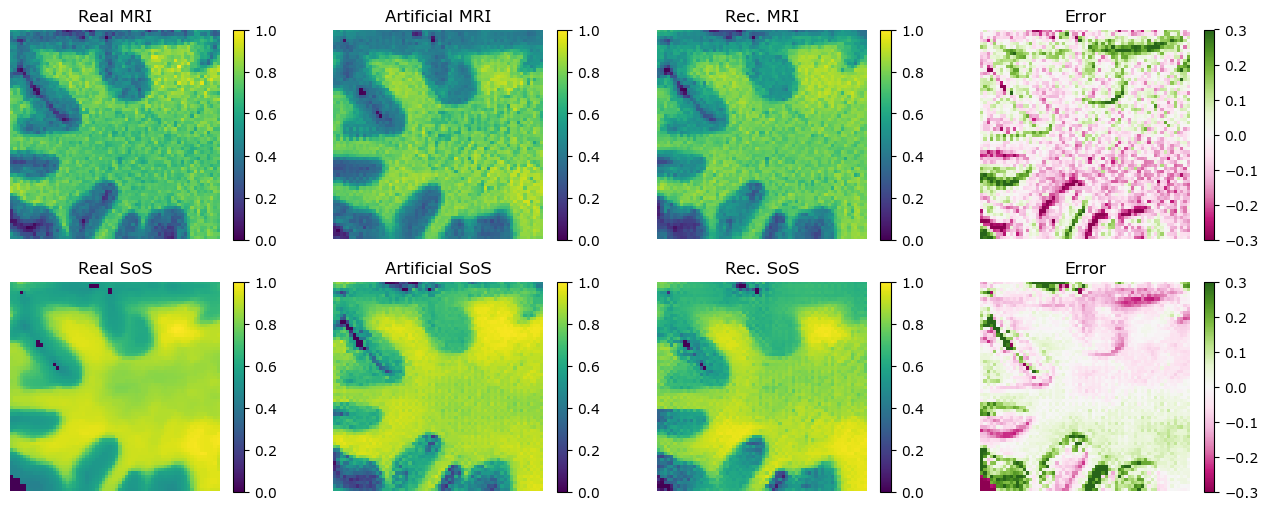

In [14]:
s=0
test_fake_mris = []
test_fake_soss = []
test_rec_mris = []
test_rec_soss = []
G_A2B, G_B2A, D_A, D_B=load_models(name[s])
G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
for i in range(len(test_mris)):
    real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
    fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
    rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

    real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
    fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
    rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

    test_fake_mris.append(fake_mri)
    test_fake_soss.append(fake_sos)
    test_rec_mris.append(rec_mri)
    test_rec_soss.append(rec_sos)

    with torch.no_grad():
        real_mri.detach().cpu()
        real_sos.detach().cpu()
n=3
print(name[s])
plt.subplots(2,4,figsize=(16,6));
plt.subplot(2,4,1);plt.imshow(test_mris[n]); plt.title('Real MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,2);plt.imshow(test_fake_mris[n][0,0,:,:]); plt.title('Artificial MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,3);plt.imshow(test_rec_mris[n][0,0,:,:]); plt.title('Rec. MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,4);plt.imshow(test_mris[n]-test_fake_mris[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
plt.subplot(2,4,5);plt.imshow(test_soss[n]); plt.title('Real SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,6);plt.imshow(test_fake_soss[n][0,0,:,:]); plt.title('Artificial SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,7);plt.imshow(test_rec_soss[n][0,0,:,:]); plt.title('Rec. SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,8);plt.imshow(test_soss[n]-test_fake_soss[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
plt.show()
